In [22]:
!pip install category_encoders==2.*
!pip install xgboost

In [23]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

# Encoders
from category_encoders import OneHotEncoder, OrdinalEncoder

In [3]:
# Data paths via Github
train_path = 'https://raw.githubusercontent.com/attyfinch/spaceship_titanic_predictive_model_kaggle/main/spaceship-titanic/train.csv'
test_path = 'https://raw.githubusercontent.com/attyfinch/spaceship_titanic_predictive_model_kaggle/main/spaceship-titanic/test.csv'

In [166]:
def wrangle(path):
    df = pd.read_csv(path)

    # Fill blanks with NaN values
    df.replace(r'^\s*$', np.nan, regex=True)

    # Rename columns
    df.rename(columns={'HomePlanet': 'home_planet',
                       'CryoSleep': 'cryosleep',
                       'Cabin': 'cabin',
                       'Destination': 'destination',
                       'Age': 'age',
                       'VIP': 'vip',
                       'RoomService': 'room_service',
                       'FoodCourt': 'food_court',
                       'ShoppingMall': 'shopping_mall',
                       'Spa': 'spa',
                       'VRDeck': 'vr_deck',
                       'Transported': 'transported',
                      }, inplace=True)

    # Replacing NaN values
    df['home_planet'].fillna(df['home_planet'].mode()[0], inplace=True)
    df['cryosleep'].fillna(df['cryosleep'].mode()[0], inplace=True)
    df['cabin'].fillna(df['cabin'].mode()[0], inplace=True)
    df['destination'].fillna(df['destination'].mode()[0], inplace=True)
    df['age'].fillna(df['age'].median(), inplace=True)
    df['vip'].fillna(df['vip'].mode()[0], inplace=True)
    df['room_service'].fillna(df['room_service'].mode()[0], inplace=True)
    df['food_court'].fillna(df['food_court'].mode()[0], inplace=True)
    df['shopping_mall'].fillna(df['shopping_mall'].mode()[0], inplace=True)
    df['spa'].fillna(df['spa'].mode()[0], inplace=True)
    df['vr_deck'].fillna(df['vr_deck'].mode()[0], inplace=True)

    # Turn Bool columns into binary values
    df['cryosleep'] = df['cryosleep'].astype(int)
    df['vip'] = df['vip'].astype(int)
    df['transported'] = df['transported'].astype(int)

    # Drop columns due to various reasons, like HCCC
    df.drop(columns=['Name'], inplace=True)

    # deck, num, side features
    df['deck'] = df['cabin'].str.split('/', expand=True)[0]
    df['side'] = df['cabin'].str.split('/', expand=True)[2]
    df.drop(columns=['cabin'], inplace=True)

    # group number feature
    df['group_number'] = df['PassengerId'].str.split('_', expand=True)[0]
    df['group_number'] = df['group_number'].astype(int)

    group_df = (
        df.groupby(by='group_number')
        .agg(group_size = ('group_number', 'count'))
        .reset_index()
        )

    # inserting group size feature into df
    df = df.merge(group_df, on='group_number', how='left')
    df.drop(columns=['group_number'], inplace=True)

    df.set_index('PassengerId', inplace=True)
    return df

df = wrangle(train_path)
df.head()

,home_planet,cryosleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,deck,side,group_size
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P,1
0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S,1
0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S,2
0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S,2
0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S,1


### Feature Engineering Notes

Yielded results
- Eliminating number column
- Splitting home + dest back into separate cols
- Breaking ammenities spend back into individual cols
- Keeping deck and side separate

Some possible updates to my current wrangle function:
- Add age brackets, and tune grouping numbers

# Split Data

In [5]:
target = 'transported'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline

In [6]:
baseline_acc = y_train.value_counts(normalize=True).max()
print(f'Baseline Accuracy: {baseline_acc}')

Baseline Accuracy: 0.5033074489502445


#Model Comparison



In [41]:
gb_model = make_pipeline(
    OneHotEncoder(),
    GradientBoostingClassifier(random_state=42)
)

gb_model.fit(X_train, y_train)

rf_model = make_pipeline(
    OneHotEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

rf_model.fit(X_train, y_train)

xgb_model = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(random_state=42)
)

xgb_model.fit(X_train, y_train)


print('Gradiant Boost', gb_model.score(X_test, y_test))
print('Random Forest Boost', rf_model.score(X_test, y_test))
print('XG Boost', xgb_model.score(X_test, y_test))

# XG Boost performs the best. I will move forwarding with tuning this model

Gradiant Boost 0.7855089131684876
Random Forest Boost 0.7832087406555491
XG Boost 0.7906843013225991


# XG Boost Model Tuning

Tuning the model in a way that helps me define parameter ranges for a grid search.

In [52]:
# Examining column contributions

cols = X_train.columns

for col in cols:
  X_train_mod = X_train.drop(columns=col)
  X_test_mod = X_test.drop(columns=col)

  xgb_model_mod = make_pipeline(
    OneHotEncoder(),
    XGBClassifier(random_state=42)
  )

  xgb_model_mod.fit(X_train_mod, y_train)

  print(col, xgb_model_mod.score(X_test_mod, y_test) - 0.7906843013225991)

# All columns add to model performance

home_planet -0.006325474410580734
cryosleep -0.006900517538815376
destination -0.0017251293847038163
age -0.0017251293847038163
vip -0.0005750431282345314
room_service -0.006325474410580734
food_court -0.006325474410580734
shopping_mall -0.00517538815411156
spa -0.010925819436457651
vr_deck -0.02357676825761923
deck -0.009775733179988477
side -0.0023001725129384587
group_size -0.0074755606670500185


In [167]:
model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=68)
)
model.fit(X_train, y_train)

print('Train', model.score(X_train, y_train))
print('Test', model.score(X_test, y_test))

Train 0.8862525165372448
Test 0.8004600345025877


0.8004600345025877


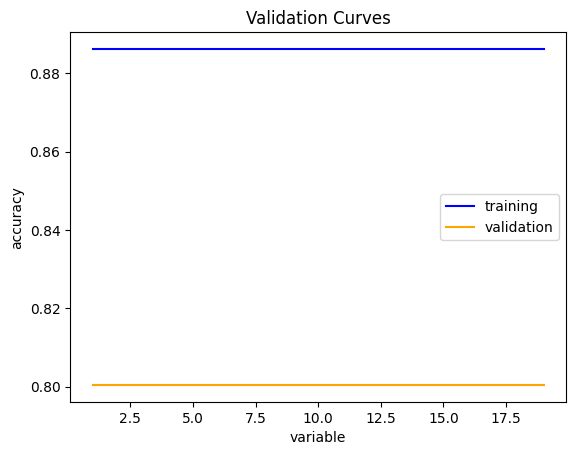

In [116]:
# Tuning individual variables
max_depth = np.arange(1, 20, 1)
n_estimators = np.arange(50, 70, 1)
learning_rate = np.arange(0.1, 1, 0.1)
reg_lambda = np.arange(0.1, 1, 0.1)
reg_alpha = np.arange(0.1, 1, 0.1)
subsample = np.arange(0.1, 1, 0.1)
sampling_method = np.arange(0.5, 1, 0.1)
max_leaves = np.arange(1, 30, 1)
max_cat_threshold = np.arange(1, 20, 1)

# Objective

variable = max_cat_threshold

train_acc = []
val_acc = []

for val in variable:
  model_tune = make_pipeline(
      OrdinalEncoder(),
      XGBClassifier(n_estimators=68, max_cat_threshold=val)
  )
  model_tune.fit(X_train, y_train)
  train_acc.append(model_tune.score(X_train, y_train))
  val_acc.append(model_tune.score(X_test, y_test))

print(max(val_acc))
plt.plot(variable, train_acc, color='blue', label='training')
plt.plot(variable, val_acc, color='orange', label='validation')
plt.xlabel('variable')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES!
plt.legend()
plt.show()

In [38]:
# Base model I update with best params

model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=55, max_depth=12, max_samples=0.7)
)

model.fit(X_train, y_train)

print('train score', model.score(X_train, y_train))
print('test score', model.score(X_test, y_test))

train score 0.8848144952545298
test score 0.7975848188614146


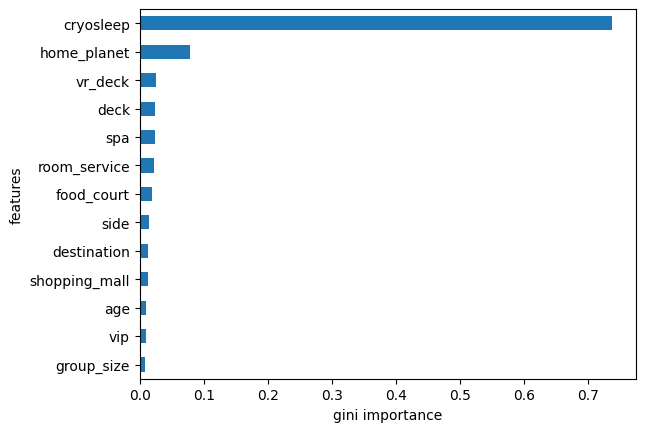

In [118]:
features = model.named_steps['ordinalencoder'].get_feature_names()
gini_importances = model.named_steps['xgbclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(40).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

# GB Model Tuning

In [158]:
cols = X_train.columns

for col in cols:
  X_train_mod = X_train.drop(columns=col)
  X_test_mod = X_test.drop(columns=col)

  gb_model_mod = make_pipeline(
    OneHotEncoder(),
    GradientBoostingClassifier(random_state=42, learning_rate=0.3, n_estimators=130, subsample=0.5)
  )

  gb_model_mod.fit(X_train_mod, y_train)

  print(col, gb_model_mod.score(X_test_mod, y_test) - 0.7998849913743531)

# All columns add to model performance

home_planet -0.005750431282346202
cryosleep -0.01322599194939622
destination -0.012650948821161578
age -0.01552616446233468
vip -0.021851638872915524
room_service -0.016676250718803964
food_court -0.009775733179988477
shopping_mall -0.01035077630822312
spa -0.029902242668200185
vr_deck -0.024726854514088625
deck -0.018976423231742423
side -0.008050603795284661
group_size -0.008050603795284661


In [155]:
X_train_optimized = X_train.drop(columns=['room_service', 'side'])
X_test_optimized = X_test.drop(columns=['room_service', 'side'])

gb_model = make_pipeline(
    OneHotEncoder(),
    GradientBoostingClassifier(random_state=42, learning_rate=0.3, n_estimators=130, subsample=0.5)
)

gb_model.fit(X_train, y_train)
print(gb_model.score(X_test, y_test))

# dropping room_service and side improves base model

0.7998849913743531


0.7998849913743531


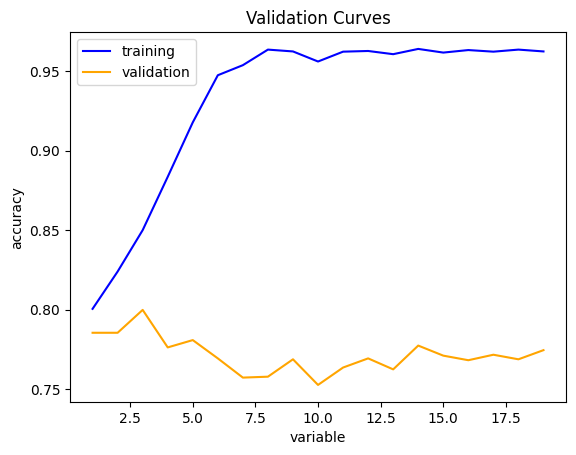

In [152]:
# Tuning individual variables
max_depth = np.arange(1, 20, 1)
n_estimators = np.arange(5, 200, 5)
learning_rate = np.arange(0.05, 1, 0.05)
subsample = np.arange(0.05, 1, 0.05)
min_samples_split = np.arange(0.01, 1, 0.01)

# Objective

variable = max_depth

train_acc = []
val_acc = []

for val in variable:
  model_tune = make_pipeline(
      OneHotEncoder(),
      GradientBoostingClassifier(random_state=42, learning_rate=0.3, subsample=0.5, n_estimators=130)
  )
  model_tune.fit(X_train, y_train)
  train_acc.append(model_tune.score(X_train, y_train))
  val_acc.append(model_tune.score(X_test, y_test))

print(max(val_acc))
plt.plot(variable, train_acc, color='blue', label='training')
plt.plot(variable, val_acc, color='orange', label='validation')
plt.xlabel('variable')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES!
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


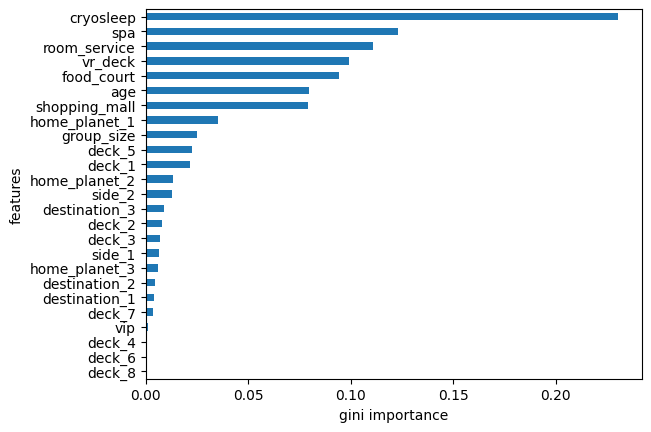

In [161]:
features = gb_model.named_steps['onehotencoder'].get_feature_names()
gini_importances = gb_model.named_steps['gradientboostingclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(40).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

# Predictions

Preparing data for Kaggle submission

In [182]:
def wrangle_test(path):
    df = pd.read_csv(path)

    # Fill blanks with NaN values
    df.replace(r'^\s*$', np.nan, regex=True)

    # Rename columns
    df.rename(columns={'HomePlanet': 'home_planet',
                       'CryoSleep': 'cryosleep',
                       'Cabin': 'cabin',
                       'Destination': 'destination',
                       'Age': 'age',
                       'VIP': 'vip',
                       'RoomService': 'room_service',
                       'FoodCourt': 'food_court',
                       'ShoppingMall': 'shopping_mall',
                       'Spa': 'spa',
                       'VRDeck': 'vr_deck'
                      }, inplace=True)

    # Replacing NaN values
    df['home_planet'].fillna(df['home_planet'].mode()[0], inplace=True)
    df['cryosleep'].fillna(df['cryosleep'].mode()[0], inplace=True)
    df['cabin'].fillna(df['cabin'].mode()[0], inplace=True)
    df['destination'].fillna(df['destination'].mode()[0], inplace=True)
    df['age'].fillna(df['age'].median(), inplace=True)
    df['vip'].fillna(df['vip'].mode()[0], inplace=True)
    df['room_service'].fillna(df['room_service'].mode()[0], inplace=True)
    df['food_court'].fillna(df['food_court'].mode()[0], inplace=True)
    df['shopping_mall'].fillna(df['shopping_mall'].mode()[0], inplace=True)
    df['spa'].fillna(df['spa'].mode()[0], inplace=True)
    df['vr_deck'].fillna(df['vr_deck'].mode()[0], inplace=True)

    # Turn Bool columns into binary values
    df['cryosleep'] = df['cryosleep'].astype(int)
    df['vip'] = df['vip'].astype(int)

    # Drop columns due to various reasons, like HCCC
    df.drop(columns=['Name'], inplace=True)

    # deck, num, side features
    df['deck'] = df['cabin'].str.split('/', expand=True)[0]
    df['side'] = df['cabin'].str.split('/', expand=True)[2]
    df.drop(columns=['cabin'], inplace=True)

    # group number feature
    df['group_number'] = df['PassengerId'].str.split('_', expand=True)[0]
    df['group_number'] = df['group_number'].astype(int)

    group_df = (
        df.groupby(by='group_number')
        .agg(group_size = ('group_number', 'count'))
        .reset_index()
        )

    # inserting group size feature into df
    df = df.merge(group_df, on='group_number', how='left')
    df.drop(columns=['group_number'], inplace=True)

    df.set_index('PassengerId', inplace=True)
    return df

In [200]:
X_test_submit = wrangle_test(test_path)
predictions = pd.DataFrame(data=model.predict(X_test_submit), index=X_test_submit.index)
predictions.columns = ['Transported']

predictions.loc[predictions['Transported'] == 1, 'Transported'] = True
predictions.loc[predictions['Transported'] == 0, 'Transported'] = False
predictions

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True
